<a href="https://colab.research.google.com/github/marxav/hello-world-python/blob/master/artificial_neural_network_101_numpy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#  Goal: implement an artificial neural network from scratch


The trickiest part is the backpropagation algorithm.

As a reference, read:
* the **Neural Networks and Deep Learning** free online book from Michael Nielsen, in particular, chapter 2: http://neuralnetworksanddeeplearning.com/chap2.html
* https://github.com/SkalskiP/ILearnDeepLearning.py/blob/master/01_mysteries_of_neural_networks/03_numpy_neural_net/Numpy%20deep%20neural%20network.ipynb, which served as an awesome guideline for this code

## Import the tools

In [1]:
import numpy as np
import matplotlib.pyplot as plt

## Get the data

In [2]:
X_train = np.array([0.765,0.838,0.329,0.277,0.45,0.833,0.44,0.634,0.351,0.784,0.589,0.816,0.352,0.591,0.04,0.38,0.816,0.732,0.32,0.597,0.908,0.146,0.691,0.75,0.568,0.866,0.705,0.027,0.607,0.793,0.864,0.057,0.877,0.164,0.729,0.291,0.324,0.745,0.158,0.098,0.113,0.794,0.452,0.765,0.983,0.001,0.474,0.773,0.155,0.875,])
Y_train = np.array([6.322,6.254,3.224,2.87,4.177,6.267,4.088,5.737,3.379,6.334,5.381,6.306,3.389,5.4,1.704,3.602,6.306,6.254,3.157,5.446,5.918,2.147,6.088,6.298,5.204,6.147,6.153,1.653,5.527,6.332,6.156,1.766,6.098,2.236,6.244,2.96,3.183,6.287,2.205,1.934,1.996,6.331,4.188,6.322,5.368,1.561,4.383,6.33,2.192,6.108,])
X_test = np.array([0.329,0.528,0.323,0.952,0.868,0.931,0.69,0.112,0.574,0.421,0.972,0.715,0.7,0.58,0.69,0.163,0.093,0.695,0.493,0.243,0.928,0.409,0.619,0.011,0.218,0.647,0.499,0.354,0.064,0.571,0.836,0.068,0.451,0.074,0.158,0.571,0.754,0.259,0.035,0.595,0.245,0.929,0.546,0.901,0.822,0.797,0.089,0.924,0.903,0.334,])
Y_test = np.array([3.221,4.858,3.176,5.617,6.141,5.769,6.081,1.995,5.259,3.932,5.458,6.193,6.129,5.305,6.081,2.228,1.912,6.106,4.547,2.665,5.791,3.829,5.619,1.598,2.518,5.826,4.603,3.405,1.794,5.23,6.26,1.81,4.18,1.832,2.208,5.234,6.306,2.759,1.684,5.432,2.673,5.781,5.019,5.965,6.295,6.329,1.894,5.816,5.951,3.258,])

## Build the artificial neural-network

In [3]:
# You may modify it and add intermediary units, or even one or more hidden layers
ANN_ARCHITECTURE = [
    {"input_dim": 1, "output_dim": 8, "activation": "relu"},
    #{"input_dim": 8, "output_dim": 8, "activation": "relu"},
    {"input_dim": 8, "output_dim": 1, "activation": "none"},
]

In [4]:
def init_parameters(ann_architecture):
   
    # number of layers in our neural network
    number_of_layers = len(ann_architecture)
    
    # parameters storage initiation
    params_values = {}
    
    # iteration over network layers
    for idx, layer in enumerate(ann_architecture):
        
        # we number network layers from 1
        layer_idx = idx + 1
        
        # extracting the number of units in layers
        layer_input_size = layer["input_dim"]
        layer_output_size = layer["output_dim"]
        
        # initiating the values of the W matrix
        # and vector b for subsequent layers
        params_values['W' + str(layer_idx)] = np.random.randn(
            layer_output_size, layer_input_size) * 0.1
        params_values['b' + str(layer_idx)] = np.random.randn(
            layer_output_size, 1) * 0.1
        
    return params_values

In [5]:
# activation functions and their derivative

def sigmoid(Z):
    return 1/(1 +np.exp(-Z))

def sigmoid_prime(dA, Z):
    sig = sigmoid(Z)
    return dA * sig * (1 - sig)

def relu(Z):
    return np.maximum(0, Z)

def relu_prime(dA, Z):
    dZ = np.array(dA, copy = True)
    dZ[Z <= 0] = 0;
    return dZ

$$\boldsymbol{Z}^{[l]} = \boldsymbol{W}^{[l]} \cdot \boldsymbol{A}^{[l-1]} + \boldsymbol{b}^{[l]}$$

$$\boldsymbol{A}^{[l]} = g^{[l]}(\boldsymbol{Z}^{[l]})$$

In [6]:
def single_layer_forward_propagation(A_prev, W_curr, b_curr, activation):
    
    # calculation of the input value for the activation function
    Z_curr = np.dot(W_curr, A_prev) + b_curr
    
    # selection of activation function
    if activation is "none":
        return Z_curr, Z_curr
    elif activation is "relu":
        activation_func = relu
    elif activation is "sigmoid":
        activation_func = sigmoid
    else:
        raise Exception('Non-supported activation function')
        
    # return of calculated activation A and the intermediate Z matrix
    return activation_func(Z_curr), Z_curr

In [7]:
def full_forward_propagation(X, params_values, ann_architecture):
    
    # if needed, transform X = [ 1, 2, 3] into X = [[1, 2, 3]] 
    if len(X.shape) == 1:
        X = np.transpose(X.reshape(X.shape[0], 1))
        
    # creating a temporary memory to store the information needed for a backward step    
    memory = {}
    
    # X vector is the activation for layer 0 
    A_curr = X
    
    # iteration over network layers
    for idx, layer in enumerate(ann_architecture):
        # we number network layers from 1
        layer_idx = idx + 1
        # transfer the activation from the previous iteration
        A_prev = A_curr
        
        # extraction of the activation function for the current layer
        activ_function_curr = layer["activation"]
        
        # extraction of W for the current layer
        W_curr = params_values["W" + str(layer_idx)]
        # extraction of b for the current layer
        b_curr = params_values["b" + str(layer_idx)]
        # calculation of activation for the current layer
        A_curr, Z_curr = single_layer_forward_propagation(A_prev, W_curr, b_curr, activ_function_curr)
        
        # saving calculated values in the memory
        memory["A" + str(idx)] = A_prev
        memory["Z" + str(layer_idx)] = Z_curr
       
    # return of prediction vector and a dictionary containing intermediate values
    return A_curr, memory

In [8]:
def get_cost_value(Y_hat, Y):
    # return Mean Square Error
    return np.square(np.subtract(Y_hat,Y)).mean()

![Network architecture](https://miro.medium.com/max/1022/1*fX0kutywUnSTlDVS-yKdZA.png)

**Figure**: The four main formula of backpropagation at each layer. For more detail refer to http://neuralnetworksanddeeplearning.com/chap2.html

In [9]:
def single_layer_backward_propagation(dA_curr, W_curr, b_curr, Z_curr, A_prev, activation):
    
    # calculation dZ_curr (a.k.a. BP1)
    if activation is "none":
        dZ_curr = dA_curr
    else:
        if activation is "relu":
            backward_activation_func = relu_prime
        elif activation is "sigmoid":
            backward_activation_func = sigmoid_prime
        else:
            raise Exception('Non-supported activation function')
        
        # calculation of the activation function derivative
        dZ_curr = backward_activation_func(dA_curr, Z_curr)

    # derivative of the matrix A_prev (a.k.a. BP2)
    dA_prev = np.dot(W_curr.T, dZ_curr)

    # derivative of the vector b (a.k.a. BP3)
    db_curr = np.sum(dZ_curr, axis=1, keepdims=True)
    
    # derivative of the matrix W (a.k.a. BP4)
    dW_curr = np.dot(dZ_curr, A_prev.T)        
    
    return dA_prev, dW_curr, db_curr

In [10]:
def full_backward_propagation(Y_hat, Y, memory, params_values, ann_architecture):
    
    grads_values = {}
    
    # number of examples
    m = Y.shape[1]
    
    # a hack ensuring the same shape of the prediction vector and labels vector
    Y = Y.reshape(Y_hat.shape)
    
    # initiation of gradient descent algorithm
    dA_prev = Y_hat - Y
    
    for layer_idx_prev, layer in reversed(list(enumerate(ann_architecture))):
        
        # we number network layers from 1
        layer_idx_curr = layer_idx_prev + 1
        
        # extraction of the activation function for the current layer
        activation_function_curr = layer["activation"]    
        
        dA_curr = dA_prev
        
        A_prev = memory["A" + str(layer_idx_prev)]
        Z_curr = memory["Z" + str(layer_idx_curr)]
        
        W_curr = params_values["W" + str(layer_idx_curr)]
        b_curr = params_values["b" + str(layer_idx_curr)]
        
        dA_prev, dW_curr, db_curr = single_layer_backward_propagation(
            dA_curr, W_curr, b_curr, Z_curr, A_prev, activation_function_curr)
        
        grads_values["dW" + str(layer_idx_curr)] = dW_curr
        grads_values["db" + str(layer_idx_curr)] = db_curr
    
    return grads_values

For each $l = L, L-1, \ldots, 2$:
* **update** the weights according to the rule $w^l \rightarrow w^l-\frac{\eta}{m} \sum_x \delta^{x,l} (a^{x,l-1})^T$

* **update** the biases according to the rule $b^l \rightarrow b^l-\frac{\eta}{m} \sum_x \delta^{x,l}$

In [11]:
def update(params_values, grads_values, ann_architecture, learning_rate, m):

    # iteration over network layers
    for layer_idx, layer in enumerate(ann_architecture, 1):
        params_values["W" + str(layer_idx)] -= learning_rate * grads_values["dW" + str(layer_idx)] / m    
        params_values["b" + str(layer_idx)] -= learning_rate * grads_values["db" + str(layer_idx)] / m

    return params_values;

In [12]:
def fit(X, Y, ann_architecture, params_values, learning_rate, batch_size):
    
    # if needed, transform X = [ 1, 2, 3] into X = [[1, 2, 3]] 
    if len(X.shape) == 1:
        X = np.transpose(X.reshape(X.shape[0], 1))
    if len(Y.shape) == 1:
        Y = np.transpose(Y.reshape(Y.shape[0], 1))
    
    # performing calculations for subsequent iterations
    Y_hat, memory = full_forward_propagation(X, params_values, ann_architecture)
        
    # calculating metrics and saving them in history
    cost = get_cost_value(Y_hat, Y)
       
    # step backward - calculating gradient
    grads_values = full_backward_propagation(Y_hat, Y, memory, params_values, ann_architecture)
    
    # updating model state
    if X.shape[1] != batch_size: 
        raise Exception('X contains ', m, 'elements, (batch of ', batch_size, ' expected')
        
    params_values = update(params_values, grads_values, ann_architecture, learning_rate, batch_size)
        
    return params_values, cost

## Train the artificial neural-network model

In [13]:
# Object for storing training results (similar to Tensorflow object)
history = {
    'train_loss': [],
    'valid_loss': []
}

In [14]:
params_values = init_parameters(ANN_ARCHITECTURE)

# training loop
# implementation of the stochastic gradient descent
EPOCHS = 5000
for epoch in range(EPOCHS):
    
    batch_size = 1
    
    for i in range(int(X_train.shape[0]/batch_size)):
        si = i * batch_size
        sj = (i + 1) * batch_size

        params_values, train_loss = fit(
            np.transpose(X_train[si:sj]), 
            np.transpose(Y_train[si:sj]),
            ANN_ARCHITECTURE, 
            params_values, 
            0.01, 
            batch_size) 
    
    Ŷ_train, _ = full_forward_propagation(X_train, params_values, ANN_ARCHITECTURE)
    train_loss = get_cost_value(Ŷ_train, Y_train).mean()
    
    Ŷ_test, _ = full_forward_propagation(X_test, params_values, ANN_ARCHITECTURE)
    valid_loss = get_cost_value(Ŷ_test, Y_test).mean()
    
    history['train_loss'].append(train_loss)
    history['valid_loss'].append(valid_loss)

    
    if epoch % 1000 == 0:
        print('Epoch:%d, train_loss:%.2f, valid_loss:%.2f' % (epoch, train_loss, valid_loss))
        

Epoch:0, train_loss:7.92, valid_loss:6.72
Epoch:1000, train_loss:0.04, valid_loss:0.04
Epoch:2000, train_loss:0.02, valid_loss:0.02
Epoch:3000, train_loss:0.02, valid_loss:0.02
Epoch:4000, train_loss:0.02, valid_loss:0.02


## Evaluate the model

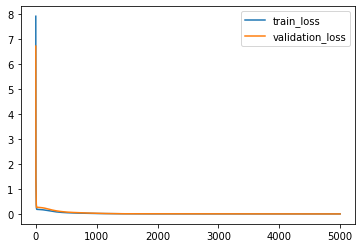

In [15]:
plt.plot(history['train_loss'], label = 'train_loss')
plt.plot(history['valid_loss'], label = 'validation_loss')
plt.legend()
plt.show()

## Predict new output data¶

In [16]:
X_new = np.array([0., 0.2, 0.4, 0.6, 0.8, 1.0])
Ŷ_new, _ = full_forward_propagation(X_new, params_values, ANN_ARCHITECTURE)
Ŷ_new

array([[1.19981022, 2.57559   , 3.95136979, 5.32714957, 6.32528569,
        5.38748569]])

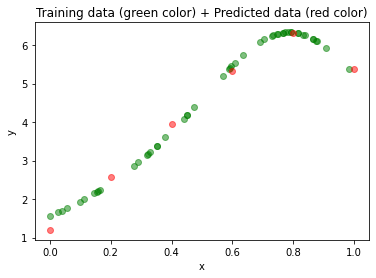

In [17]:
# Display training data and predicted data graphically
plt.title('Training data (green color) + Predicted data (red color)')

# training data in green color
plt.scatter(X_train, Y_train, color='green',  alpha=0.5)

# training data in green color
#plt.scatter(X_test, Ŷ_test, color='blue',  alpha=0.5)

# predicted data in blue color
plt.scatter(X_new, Ŷ_new, color='red',  alpha=0.5)

plt.xlabel('x')
plt.ylabel('y')
plt.show()